## Training the Vision Transformer on a Custom Dataset

In this notebook, we are going to fine-tune a pre-trained Vision Transformer (which can be found from [Huggingface](https://github.com/huggingface/transformers)) on a Custom Dataset. For this notebook we will be using the Rock, Paper, Scissors dataset which can be found [here](https://public.roboflow.com/classification/rock-paper-scissors/1). This dataset is a collection of 2925 images images in 3 different classes. This tutorial is based on Huggingface's [Fine tuning the Vision Transformer on CIFAR 10 notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train the HuggingFace Vision Transformer On a Custom Dataset](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) concurrently.


We will prepare the data using [Roboflow's Preprocessing Tools](https://docs.roboflow.com/image-transformations/image-preprocessing), and train the model using this notebook.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train a Vision Transformer on your custom classification data.

To train our image classifier we take the following steps:

* Install Vision Transformer dependencies
* Download custom Image Classification data using Roboflow
* Use the Vision Transformer Feature Extractor
* Run the Vision Transformer training procedure
* Evaluate the Vision Transformer on a test image
* Export the Vision Transformer model for future inference


### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



Let's start by installing the relevant libraries.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

# Download the Data

We'll preprocess and download our dataset from Roboflow. To preprocess the images, change the size of the image to 224x224. To download the dataset, use the "**Folder Structure**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

Note: This data has already been preprocessed through Roboflow; we HIGHLY reccommend you follow the [accompanying blog](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) as you go through this notebook.

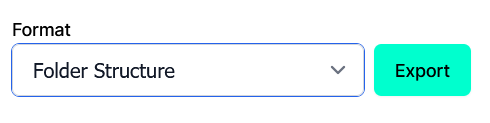

In [2]:
# !curl -L "https://universe.roboflow.com/ds/DHDKeKqxg0?key=tUkMAIncVI" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:

In [3]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('train/', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('valid/', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('test/', transform=ToTensor())

## Define the Model

Here we define the model.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.

In [4]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

/home/aravind/anaconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the Model Parameters

To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [5]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [6]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()
device

/home/aravind/anaconda3/envs/yolov8/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


device(type='cuda')

## Train the Model

In [8]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim import AdamW

# ✅ Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Define Model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(train_ds.classes)  # Number of classes
)
model.to(device)

# ✅ Feature Extractor (Disable Double Scaling)
feature_extractor = ViTFeatureExtractor.from_pretrained(
    'google/vit-base-patch16-224-in21k', do_rescale=False
)

# ✅ Define Data Augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

# ✅ Apply transformations
train_ds.transform = train_transforms
test_ds.transform = test_transforms

# ✅ Define Data Loaders
BATCH_SIZE = 16  # Recommended batch size
train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ✅ Define Optimizer with Weight Decay
LEARNING_RATE = 5e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# ✅ Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

# ✅ Learning Rate Scheduler (Reduce LR on Plateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# ✅ Training Loop
EPOCHS = 10  # Increased for better training
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for step, (x, y) in enumerate(train_loader):
        # Apply feature extractor
        x = feature_extractor(x, return_tensors="pt", padding=True)['pixel_values']
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()  # Reset gradients
        output = model(x).logits  # Get logits

        loss = loss_func(output, y)  # Compute loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (output.argmax(1) == y).sum().item()
        total += y.size(0)

        if step % 50 == 0:
            print(f'Epoch {epoch}, Step {step}, Loss: {loss.item():.4f}')

    # Compute training accuracy
    train_acc = correct / total
    avg_loss = total_loss / len(train_loader)
    print(f'✅ Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.2f}')

    # ✅ Run evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = feature_extractor(x, return_tensors="pt", padding=True)['pixel_values']
            x, y = x.to(device), y.to(device)

            output = model(x).logits
            predictions = output.argmax(1)

            correct += (predictions == y).sum().item()
            total += y.size(0)

    test_acc = correct / total
    print(f'🎯 Epoch {epoch} | Test Accuracy: {test_acc:.2f}')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/aravind/anaconda3/envs/yolov8/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Step 0, Loss: 3.8446
Epoch 0, Step 50, Loss: 3.7426
Epoch 0, Step 100, Loss: 3.4042
Epoch 0, Step 150, Loss: 2.9491
Epoch 0, Step 200, Loss: 2.6307
✅ Epoch 0 | Train Loss: 3.3209 | Train Accuracy: 0.38
🎯 Epoch 0 | Test Accuracy: 0.65
Epoch 1, Step 0, Loss: 2.5321
Epoch 1, Step 50, Loss: 2.1717
Epoch 1, Step 100, Loss: 2.0095
Epoch 1, Step 150, Loss: 1.8824
Epoch 1, Step 200, Loss: 1.7473
✅ Epoch 1 | Train Loss: 2.0328 | Train Accuracy: 0.82
🎯 Epoch 1 | Test Accuracy: 0.85
Epoch 2, Step 0, Loss: 1.4754
Epoch 2, Step 50, Loss: 1.0767
Epoch 2, Step 100, Loss: 0.9683
Epoch 2, Step 150, Loss: 1.0438
Epoch 2, Step 200, Loss: 0.7914
✅ Epoch 2 | Train Loss: 1.1616 | Train Accuracy: 0.92
🎯 Epoch 2 | Test Accuracy: 0.90
Epoch 3, Step 0, Loss: 0.7853
Epoch 3, Step 50, Loss: 0.6719
Epoch 3, Step 100, Loss: 0.6779
Epoch 3, Step 150, Loss: 0.7307
Epoch 3, Step 200, Loss: 0.4954
✅ Epoch 3 | Train Loss: 0.6484 | Train Accuracy: 0.96
🎯 Epoch 3 | Test Accuracy: 0.93
Epoch 4, Step 0, Loss: 0.427

## Evaluate on a Test Image

Finally, let's evaluate the model on a test image:

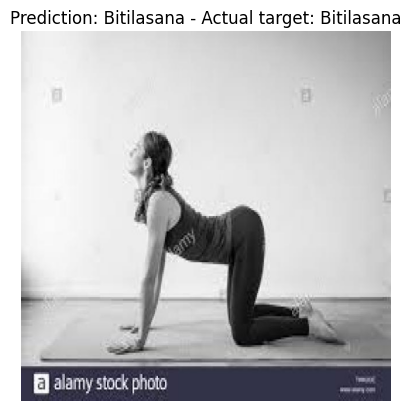

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ✅ Use DataLoader to get a single sample
EVAL_BATCH = 1
eval_loader = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4)

# Disable gradient calculation for inference
with torch.no_grad():
    inputs, target = next(iter(eval_loader))

    # Move to CPU for visualization
    original_image = inputs[0].cpu()  # Shape: [C, H, W]

    # Convert to [H, W, C] format for displaying with Matplotlib
    original_image = original_image.permute(1, 2, 0).numpy()

    # Normalize pixel values back to [0,1] range if needed
    original_image = np.clip(original_image, 0, 1)

    # ✅ Apply the feature extractor to resize and preprocess correctly
    inputs = feature_extractor(images=inputs, return_tensors="pt")['pixel_values']

    # Move to device
    inputs = inputs.to(device)  # Send to GPU/CPU
    target = target.to(device)

    # ✅ Get model output
    output = model(inputs)
    logits = output.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Convert indices to class labels
    value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target.item())]

    # ✅ Show the image correctly
    plt.imshow(original_image)
    plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
    plt.axis("off")  # Hide axes for a clean image
    plt.show()


## Save the Entire Model

We can save the entire model as follows:

In [21]:
torch.save(model.state_dict(), '/home/aravind/Documents/Parthvi_project/model_weights.pt')

## Use your Exported Model

In [22]:
MODEL_PATH = '/home/aravind/Documents/Parthvi_project/model.pt'
model.load_state_dict(torch.load('/home/aravind/Documents/Parthvi_project/model_weights.pt', map_location='cpu'))
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe